##  Bounding box creation

use the boundary to create the bounding box in this assignment. 

In [101]:
##Import necessary libraries
##For vector 
import geopandas as gpd
from shapely import wkb
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon

##for raster 
import rasterio
from rasterio.plot import show
from rasterio.enums import ColorInterp
import rasterio.mask
import numpy

Select the field with ID 9586 as the unit to create bounding box.

In [27]:
field = %sql select * from ag_field_segment where gridcode=9586
field = field.DataFrame()
field['geometry']=field['geometry'].apply(lambda g:wkb.loads(g, hex=True))
field_gd=gpd.GeoDataFrame(field,geometry='geometry')

1 rows affected.


        minx       miny       maxx       maxy
0 -88.460161  40.217176 -88.431548  40.238104


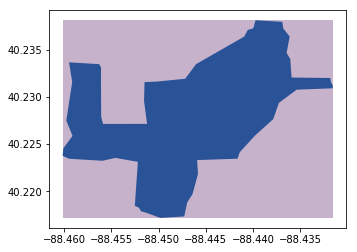

In [41]:
field_gd_bounds = field_gd.envelope
bounding_box= gpd.GeoDataFrame(gpd.GeoSeries(field_gd_bounds), columns=['geometry'])

ax = field_gd.plot()
bounding_box.plot(ax=ax, cmap='viridis', alpha=0.3)
print(field_gd.bounds)

-----------------------------------------

## Use bounding box to scope the land use data

use the minx, miny, maxx, maxy values to select features the is contained in the bounding box.

In [70]:
land_use = %sql SELECT * FROM ag_land_use WHERE ag_land_use.geometry && ST_MakeEnvelope(-88.460161, 40.217176, -88.431548, 40.238104, 4326);
land_use = land_use.DataFrame()
land_use['geometry']=land_use['geometry'].apply(lambda g:wkb.loads(g, hex=True))
land_use_gd=gpd.GeoDataFrame(land_use,geometry='geometry')

103 rows affected.


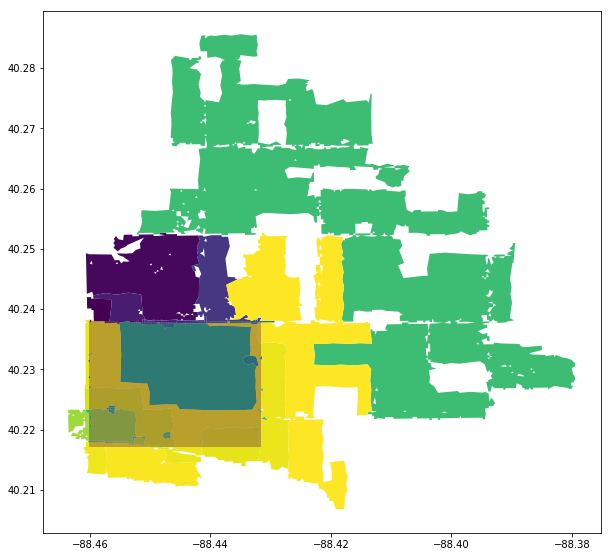

In [72]:
ax = land_use_gd.plot(cmap='viridis', figsize=(10, 10))
bounding_box.plot(ax=ax, cmap='viridis', alpha=0.3)

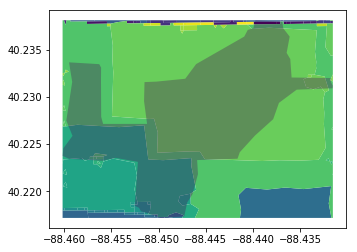

In [63]:
land_use_intersection = gpd.overlay(
    bounding_box,
    land_use_gd,
    how="intersection"
)

ax = land_use_intersection.plot(cmap='viridis',)
field_gd.plot(ax=ax, cmap='viridis',alpha=0.3)

-----------------

## Use bounding box to scope the soil type data

use the minx, miny, maxx, maxy values to select features the is contained in the bounding box.

In [65]:
soil = %sql SELECT * FROM ag_soil WHERE ag_soil.geometry && ST_MakeEnvelope(-88.460161, 40.217176, -88.431548, 40.238104, 4326);
soil = soil.DataFrame()
soil['geometry']=soil['geometry'].apply(lambda g:wkb.loads(g, hex=True))
soil_gd=gpd.GeoDataFrame(soil,geometry='geometry')

76 rows affected.


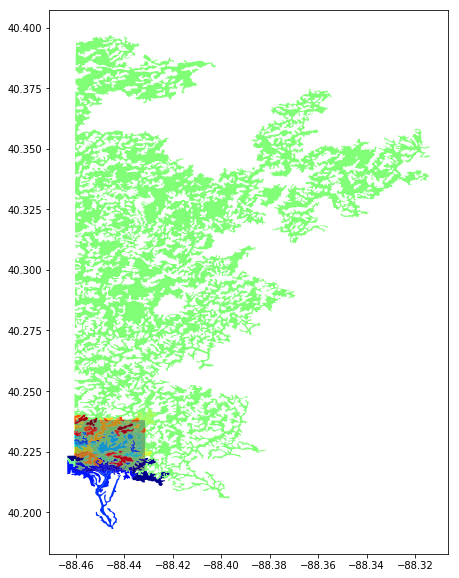

In [86]:
ax = soil_gd.plot(cmap='jet', figsize=(10, 10))
bounding_box.plot(ax=ax, cmap='viridis', alpha=0.3)

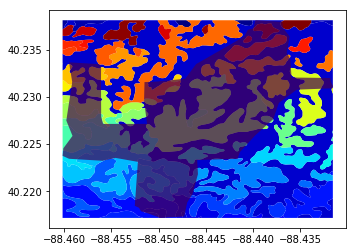

In [85]:
soil_intersection = gpd.overlay(
    bounding_box,
    soil_gd,
    how="intersection"
)

ax = soil_intersection.plot(cmap='jet',)
field_gd.plot(ax=ax, cmap='viridis',alpha=0.7)

-------------

### Calculate the statistic of data 

In [87]:
###Define funtion to calculate the area of features

def get_sqmi(row):
    feet = row.geometry.area
    return feet

#### land use data

In [95]:
land_use_intersection.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 102 entries, 0 to 102
Data columns (total 5 columns):
ogc_fid       102 non-null int64
id            102 non-null int64
gridcode      102 non-null int64
class_name    102 non-null object
geometry      102 non-null object
dtypes: int64(3), object(2)
memory usage: 4.8+ KB


In [96]:
land_use_trimmed = land_use_intersection[['class_name','geometry']]
land_use_trimmed['intersection_area'] = land_use_trimmed.apply(get_sqmi, axis=1)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,class_name,geometry,intersection_area,percent
0,Corn,"(POLYGON ((-88.460161006216 40.22687833773213,...",1.951278e-04,32.586354
1,Developed/High Intensity,POLYGON ((-88.45585781967034 40.22341080083095...,1.905354e-07,0.031819
2,Developed/Low Intensity,(POLYGON ((-88.44844397176877 40.2171761272235...,3.937676e-06,0.657592
3,Developed/Med Intensity,(POLYGON ((-88.4558636048906 40.22368099700582...,5.235650e-07,0.087435
4,Developed/Open Space,(POLYGON ((-88.44937837161019 40.2171761272235...,6.607314e-06,1.103422
5,Grassland/Pasture,(POLYGON ((-88.45655122700509 40.2228615374089...,8.199900e-06,1.369384
6,Pumpkins,POLYGON ((-88.45691529426071 40.22339749242015...,9.526766e-08,0.015910
7,Soybeans,(POLYGON ((-88.43171481694451 40.2171761272235...,3.841202e-04,64.148084


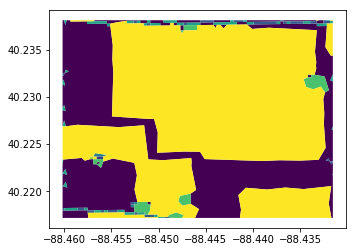

In [115]:
land_use_dissolved = land_use_trimmed.dissolve(
    by=['class_name'],
    aggfunc='sum'
).reset_index()
land_use_dissolved['percent'] = 100*land_use_dissolved['intersection_area'] / sum(land_use_dissolved['intersection_area'])

land_use_dissolved.plot(cmap='viridis')
land_use_dissolved

#### soil data

In [88]:
trimmed = soil_intersection[['musym','geometry']]
trimmed['intersection_area'] = trimmed.apply(get_sqmi, axis=1)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,musym,geometry,intersection_area,percent
0,146B2,(POLYGON ((-88.44319805993901 40.2211101003542...,0.000022,3.668976
1,149A,POLYGON ((-88.43643771969504 40.23376610405607...,0.000005,0.815662
2,152A,"(POLYGON ((-88.460161006216 40.22690626339084,...",0.000253,42.261182
3,154A,(POLYGON ((-88.45162844210729 40.2171761272235...,0.000073,12.185882
4,171B,(POLYGON ((-88.43667589440588 40.2171761272235...,0.000025,4.152365
5,198A,POLYGON ((-88.43600772732667 40.22466352490671...,0.000008,1.272205
6,223B2,(POLYGON ((-88.43369180808914 40.2205976306648...,0.000003,0.440594
7,481A,(POLYGON ((-88.44334893714537 40.2171761272235...,0.000109,18.278978
8,56B,(POLYGON ((-88.43919976665079 40.2171761272235...,0.000073,12.214671
9,622B,(POLYGON ((-88.45460080177297 40.2249582321493...,0.000014,2.385746


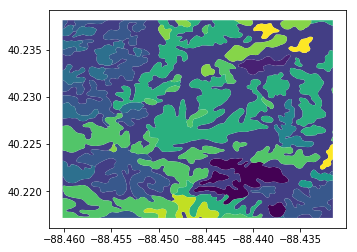

In [116]:
dissolved = trimmed.dissolve(
    by='musym',
    aggfunc='sum'
).reset_index()
dissolved['percent'] = 100*dissolved['intersection_area'] / sum(dissolved['intersection_area'])

dissolved.plot(cmap='viridis')
dissolved

----------------------------

### Raster Operations 

The the process to extract data from Landsat bands imageries

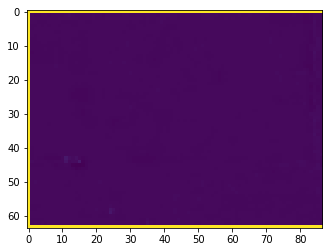

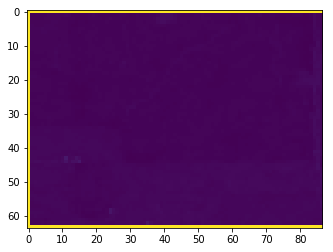

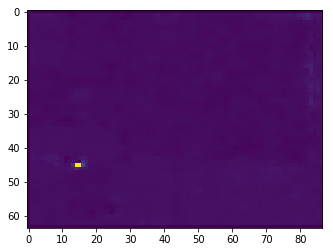

In [108]:
# Allow division by zero
numpy.seterr(divide='ignore', invalid='ignore')

red = rasterio.open('group2/test/red.tif')
nir = rasterio.open('group2/test/nir.tif')

red_clip, red_transform = rasterio.mask.mask(red, bounding_box['geometry'], crop=True)
nir_clip, nir_transform = rasterio.mask.mask(nir, bounding_box['geometry'], crop=True)

# Calculate NDVI
ndvi = (nir_clip.astype(float) - red_clip.astype(float)) / (nir_clip + red_clip)

show(red_clip)
show(nir_clip)
show(ndvi)